In [1]:
#PROJETO 14: REDES NEURAIS CONVOLUCIONAIS - JONAS GRANATYR
#ETAPA 1: IMPORTACAO DAS BIBLIOTECAS
import torch
from torch import nn, optim
from torchvision import datasets, transforms
torch.__version__

'1.9.1+cpu'

In [2]:
torch.manual_seed(123)

In [3]:
#ETAPA 2: CONSTRUCAO DO MODELO DA REDE CONVOLUCIONAL
#output = (input - filter + 1)/stride
classificador = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), #foto original para criar um mapa de caracteristicas
                             nn.ReLU(), #camada de ativacao
                             nn.BatchNorm2d(num_features=32), #normalizacao da camada
                              #(64 -3+1)/1 62x62
                             nn.MaxPool2d(kernel_size=2), #simplificacao da camada a partir do mapa de caracteristicas
                             nn.Conv2d(32,32,3),
                             nn.ReLU(),
                             nn.BatchNorm2d(32),
                              #(31-3+1)/1 = 29x29
                             nn.MaxPool2d(2),
                              #14x14
                             nn.Flatten(), #conversao da matriz de pooling(MaxPool) em vetor
                              #6272->128->128->1
                             nn.Linear(in_features=14*14*32, out_features=128), #primeira coluna de neuronios
                             nn.ReLU(),
                             nn.Dropout(0.2), #ignorando neuronios dispensaveis
                             nn.Linear(128,128), #neuronios ocultos
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(128,1), #coluna final de neuronios (1 e o neuronio gerador da resposta de classificacao)
                             nn.Sigmoid()) #funcao

In [4]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classificador.parameters())

In [5]:
#ETAPA 3: CARREGANDO OS DADOS
data_dir_train = 'training_set'
data_dir_test = 'test_set'

In [6]:
#transformador para a base de dados de treinamento/
transform_train = transforms.Compose(
    [
        transforms.Resize([64,64]), #dimensao das imagens para treinamento(64x64 pixels)
        transforms.RandomHorizontalFlip(), #alinhamento horizontal
        transforms.RandomAffine(degrees=7, translate=(0,0.07), shear=0.2, scale=(1,1.2)),
        transforms.ToTensor() #formato tensor
        ]
)

In [7]:
#aqui, queremos testar com imagens originais, portanto, nao precisamos fazer as transformacoes feitas nos dados de treinamento.
#transformador para a base de dados de teste/
transform_test = transforms.Compose(
    [
        transforms.Resize([64,64]), #dimensao das imagens para treinamento(64x64 pixels)
        transforms.ToTensor() #formato tensor
        ]
)

In [8]:
#criacao da base de dados / ImageFolder - para leitura de imagens
train_dataset = datasets.ImageFolder(data_dir_train, transform=transform_train) 
#fara a leitura das imagens e aplicara todas as transformacoes.

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [10]:
#fazendo a transformacao
#essa e a base de dados que fara de fato o treinamento
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
train_loader

In [12]:
# base de dados para testes
test_dataset = datasets.ImageFolder(data_dir_test, transform=transform_test) 

In [13]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: test_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [14]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: training_set
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomAffine(degrees=[-7.0, 7.0], translate=(0, 0.07), scale=(1, 1.2), shear=[-0.2, 0.2])
               ToTensor()
           )

In [15]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [17]:
classificador.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=6272, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=128, out_features=1, bias=True)
  (16): Sigmoid()
)

In [18]:
#TREINAMENTO DO MODELO

def training_loop (loader, epoch):
    running_loss = 0. #errors
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data #imagens e respostas
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() #zerando o gradiente
        outputs = classificador(inputs) #ira retornar o valor da ultima camada densa
        
        loss = criterion(outputs, labels.float().view(*outputs.shape)) #calculo de erros
        loss.backward()
        
        optimizer.step() #atualizando os pesos.
        
        running_loss += loss.item()
        
        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape) #verificando o valor perdito
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy
        
        #imprimindo os dados referente a esse loop
        print('\rEpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisao {:03.2f}'.format (epoch+1, i+1, len(loader),
                                                                                           loss, accuracy), end = '\r')
        
    #imprimindo os dados referrentes a essa epoca
    print('Epoca {:3d} FINALIZADA: perda {:.5f} - precisao {:.5f}'.format (epoch+1, running_loss/len(loader),
                                                                           running_accuracy/len(loader)))

In [19]:
for epoch in range(10):
    print('Treinando...')
    training_loop(train_loader, epoch)
    classificador.eval()
    print('Validando...')
    training_loop(test_loader, epoch)
    classificador.train()

Treinando...
Epoca   1 FINALIZADA: perda 0.63241 - precisao 0.644632
Validando...
Epoca   1 FINALIZADA: perda 0.58931 - precisao 0.693952
Treinando...
Epoca   2 FINALIZADA: perda 0.56116 - precisao 0.713372
Validando...
Epoca   2 FINALIZADA: perda 0.51600 - precisao 0.759921
Treinando...
Epoca   3 FINALIZADA: perda 0.51271 - precisao 0.744508
Validando...
Epoca   3 FINALIZADA: perda 0.44680 - precisao 0.806052
Treinando...
Epoca   4 FINALIZADA: perda 0.48860 - precisao 0.766628
Validando...
Epoca   4 FINALIZADA: perda 0.39359 - precisao 0.812009
Treinando...
Epoca   5 FINALIZADA: perda 0.46477 - precisao 0.783878
Validando...
Epoca   5 FINALIZADA: perda 0.30318 - precisao 0.873518
Treinando...
Epoca   6 FINALIZADA: perda 0.43758 - precisao 0.793874
Validando...
Epoca   6 FINALIZADA: perda 0.23318 - precisao 0.912700
Treinando...
Epoca   7 FINALIZADA: perda 0.42553 - precisao 0.806751
Validando...
Epoca   7 FINALIZADA: perda 0.20499 - precisao 0.917164
Treinando...
Epoca   8 FINALIZADA:

In [60]:
def classificar_imagem(fname):
    from PIL import Image
    import matplotlib.pyplot as plt
    imagem_teste = Image.open(data_dir_test + '/' + fname)
    plt.imshow(imagem_teste)
    
    import numpy as np
    imagem_teste = imagem_teste.resize((64,64))
    imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size,3)
    imagem_teste = imagem_teste/255
    imagem_teste = imagem_teste.transpose(2,0,1)
    imagem_tesste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)
    
    classificador.eval()
    imagem_teste = imagem_teste()
    output = classificador.foward(imagem_teste)
    if output > 0.5:
        output = 1
    else:
        output = 0
    print('Previsao:' ,output)
    
    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}
    return idex_to_class[output]

    

TypeError: 'numpy.ndarray' object is not callable

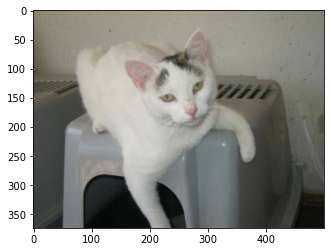

In [61]:

imagem = 'cats/cat.4046.jpg'
classificar_imagem(imagem)